<a href="https://colab.research.google.com/github/HarshGupta-DS/Predictive-Maintainence-using-Time-Series-Forecasting/blob/main/Predictive_Maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predictive Maintenance** : **Data Analysis & Prediction**


In [48]:
#Importing Libraries and defining functions for plotting the data using **matplotlib**
import os
import sys
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

matplotlib.style.use("Solarize_Light2")

%matplotlib inline

In [60]:
def check_null(df):
    """
    Returns percentage of rows containing missing data
    """
    return df.isna().sum() * 100/len(df)


def get_missing_dates(series, start_date, end_date, freq="D"):
    """
    Returns the dates which are missing in the series
    date_sr between the start_date and end_date
    
    series: Series consisting of date
    start_date: Start date in String format
    end_date: End date in String format
    """
    return pd.date_range(
        start=start_date, end=end_date, freq=freq).difference(series)


def check_duplicate(df, subset):
    """
    Returns if there are any duplicate rows in the DataFrame.
    
    df: DataFrame under consideration
    subset: Optional List of feature names based on which 
            duplicate rows are being identified. 
    """
    if subset is not None: 
        return df.duplicated(subset=subset, keep=False).sum()
    else:
        return df.duplicated(keep=False).sum()


def create_date_features(source_df, target_df, feature_name):
    '''
    Create new features related to dates
    
    source_df : DataFrame consisting of the timestamp related feature
    target_df : DataFrame where new features will be added
    feature_name : Name of the feature of date type which needs to be decomposed.
    '''
    target_df.loc[:, 'year'] = source_df.loc[:, feature_name].dt.year.astype('uint16')
    target_df.loc[:, 'month'] = source_df.loc[:, feature_name].dt.month.astype('uint8')
    target_df.loc[:, 'quarter'] = source_df.loc[:, feature_name].dt.quarter.astype('uint8')
    target_df.loc[:, 'weekofyear'] = source_df.loc[:, feature_name].dt.isocalendar().week.astype('uint8')
    
    target_df.loc[:, 'hour'] = source_df.loc[:, feature_name].dt.hour.astype('uint8')
    
    target_df.loc[:, 'day'] = source_df.loc[:, feature_name].dt.day.astype('uint8')
    target_df.loc[:, 'dayofweek'] = source_df.loc[:, feature_name].dt.dayofweek.astype('uint8')
    target_df.loc[:, 'dayofyear'] = source_df.loc[:, feature_name].dt.dayofyear.astype('uint8')
    target_df.loc[:, 'is_month_start'] = source_df.loc[:, feature_name].dt.is_month_start
    target_df.loc[:, 'is_month_end'] = source_df.loc[:, feature_name].dt.is_month_end
    target_df.loc[:, 'is_quarter_start']= source_df.loc[:, feature_name].dt.is_quarter_start
    target_df.loc[:, 'is_quarter_end'] = source_df.loc[:, feature_name].dt.is_quarter_end
    target_df.loc[:, 'is_year_start'] = source_df.loc[:, feature_name].dt.is_year_start
    target_df.loc[:, 'is_year_end'] = source_df.loc[:, feature_name].dt.is_year_end
    
    # This is of type object
    target_df.loc[:, 'month_year'] = source_df.loc[:, feature_name].dt.to_period('M')
    
    return target_df


def plot_boxh_groupby(df, feature_name, by):
    """
    Box plot with groupby
    
    df: DataFrame
    feature_name: Name of the feature to be plotted
    by: Name of the feature based on which groups are created
    """
    df.boxplot(column=feature_name, by=by, vert=False, 
                              figsize=(10, 6))
    plt.title(f'Distribution of {feature_name} by {by}')
    plt.show()
    

def plot_hist(df, feature_name, kind='hist', bins=100, log=True):
    """
    Plot histogram.
    
    df: DataFrame
    feature_name: Name of the feature to be plotted.
    """
    if log:
        df[feature_name].apply(np.log1p).plot(kind='hist', 
                                              bins=bins, 
                                              figsize=(15, 5), 
                                              title=f'Distribution of log1p[{feature_name}]')
    else:
        df[feature_name].plot(kind='hist', 
                              bins=bins, 
                              figsize=(15, 5), 
                              title=f'Distribution of {feature_name}')
    plt.show()


def plot_ts(series, figsize=(20, 6), title=None, xlabel="", ylabel=""):
    """
    Plot Time Series data. The series object should have date or time as index.
    
    series: Series object to be plotted.
    """
    series.plot(figsize=figsize, title=title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


def plot_barh(df, feature_name, normalize=True, 
              kind='barh', figsize=(15,5), sort_index=False, title=None):
    """
    Plot barh for a particular feature
    
    kind : Type of the plot
    
    """
    if sort_index==True:
        df[feature_name].value_counts(
                normalize=normalize, dropna=False).sort_index().plot(
                kind=kind, figsize=figsize, grid=True,
                title=title)
    else:   
        df[feature_name].value_counts(
                normalize=normalize, dropna=False).sort_values().plot(
                kind=kind, figsize=figsize, grid=True,
                title=title)
    
    plt.legend()
    plt.show()


def plot_boxh(df, feature_name, kind='box', log=True):
    """
    Box plot
    """
    if log:
        df[feature_name].apply(np.log1p).plot(kind='box', vert=False, 
                                                  figsize=(10, 6), 
                                                  title=f'Distribution of log1p[{feature_name}]')
    else:
        df[feature_name].plot(kind='box', vert=False, 
                              figsize=(10, 6), 
                              title=f'Distribution of {feature_name}')
    plt.show()
    

def plot_scatter(df, feature_x, feature_y, figsize=(10,10), 
                 title=None, xlabel=None, ylabel=None):
    """
    Plot satter     
    """
    df.plot.scatter(feature_x, feature_y, 
                    figsize=(8, 6), title=title, 
                    legend=None)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

Our world is full of equipment. For example:



*   Aircraft consists of different equipments
*   HVAC (Heating, Ventilation, Air Conditioning) equipment consists of various parts





All these equipments or their parts meet failures and hence need maintenance. Thus maintenance is a big industry by itself. Maintenance is done either by replacing parts at regular intervals even when those are working (Preventive Maintenance) or by replacing the parts only when there is failure (Reactive Maintenance). 

Predictive Maintenance avoids the drawbacks of Preventive Maintenance (under utilization of a part's life) and Reactive Maintenance (unscheduled downtime). Based on the health of an equipment in the past, future point of failure can be predicted in Predictive Maintenance. Thus, replacement of parts can be scheduled just before the actual failure.

Traditionally, predictive maintenance is being done using rule based techniques. With the advent of connected sensors (IoT), data from equipment is continuously collected and fed to Machine Learning based systems to predict its future health.

In [61]:
#Reading_Data
Data_Dir = "/content/drive/MyDrive"

telemetry_df = pd.read_csv("/content/drive/MyDrive/PdM_telemetry.csv")
errors_df = pd.read_csv("/content/drive/MyDrive/PdM_errors.csv")
maint_df = pd.read_csv("/content/drive/MyDrive/PdM_maint.csv")
failure_df = pd.read_csv("/content/drive/MyDrive/PdM_failures.csv")
machines_df = pd.read_csv("/content/drive/MyDrive/PdM_machines.csv")

#Date and Time Formatting, Sorting based on Date for better readability
tables = [telemetry_df,errors_df,maint_df,failure_df]
for df in tables:
  df["datetime"] = pd.to_datetime(df["datetime"], format = "%Y-%m-%d %H:%M:%S")
  df.sort_values(["datetime","machineID"],inplace=True, ignore_index = True)

In [62]:
failure_df.head()

,datetime,machineID,failure
0,2015-01-02 03:00:00,16,comp1
1,2015-01-02 03:00:00,16,comp3
2,2015-01-02 03:00:00,17,comp4
3,2015-01-02 03:00:00,22,comp1
4,2015-01-02 03:00:00,35,comp1


**Telemetry Data**

For more simplicity we will select a machine data that consist of hourly average of voltage, rotation, pressure, and vibration collected from 100 Machines.



In [63]:
#First few rows of Telemetry data for Machine 1
telemetry_df[telemetry_df.machineID==1].head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
100,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
200,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
300,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
400,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [64]:
#Machine Count
telemetry_df.machineID.nunique()

100

In [65]:
#Duration of the data
telemetry_df.datetime.describe(datetime_is_numeric=True)

count                 876100
mean     2015-07-02 18:00:00
min      2015-01-01 06:00:00
25%      2015-04-02 12:00:00
50%      2015-07-02 18:00:00
75%      2015-10-02 00:00:00
max      2016-01-01 06:00:00
Name: datetime, dtype: object

In [66]:
#Duplictes Values
check_duplicate(telemetry_df,['datetime', 'machineID'])


0

In [67]:
#Check Null Values
check_null(telemetry_df)

datetime     0.0
machineID    0.0
volt         0.0
rotate       0.0
pressure     0.0
vibration    0.0
dtype: float64

In [68]:
#Let's assume machineID as 10
print(f"Shape of the Telemetry Record: {telemetry_df.shape}")
df_sin = telemetry_df.loc[telemetry_df['machineID']==10].reset_index(drop=True)
df_sin.head(n=5)

Shape of the Telemetry Record: (876100, 6)


,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,10,158.421261,500.830885,119.750673,45.571344
1,2015-01-01 07:00:00,10,174.631951,356.928821,88.860999,35.245965
2,2015-01-01 08:00:00,10,158.777566,467.162159,84.382394,37.975278
3,2015-01-01 09:00:00,10,178.128852,438.376292,105.870821,40.836263
4,2015-01-01 10:00:00,10,176.497316,364.918330,98.148214,35.511013


In [69]:
#Failure record of Machine 10
sel_fail = failure_df.loc[failure_df['machineID']==10]
pd.DataFrame(sel_fail)

,datetime,machineID,failure
55,2015-01-19 06:00:00,10,comp2
219,2015-04-04 06:00:00,10,comp2
308,2015-05-19 06:00:00,10,comp2
338,2015-06-03 06:00:00,10,comp1
367,2015-06-18 06:00:00,10,comp2


In [70]:
#Error Record of Machine 10
sel_err = errors_df.loc[errors_df['machineID']==10]
pd.DataFrame(sel_err).head()

,datetime,machineID,errorID
10,2015-01-01 20:00:00,10,error1
67,2015-01-06 04:00:00,10,error3
193,2015-01-18 06:00:00,10,error2
194,2015-01-18 06:00:00,10,error3
247,2015-01-22 05:00:00,10,error1


As per the Kaggle Dataset, error refers to non-breaking events while failure referes to event that cause the machine to fail.

So, using chronological plot we will define how error and failure relate with each other.

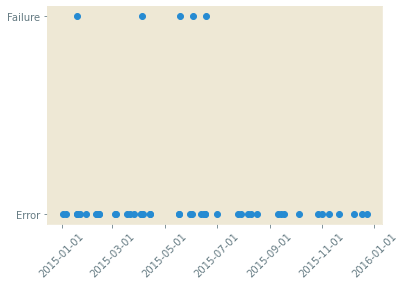

In [72]:
fig, ax = plt.subplots()

#Using two values in the y-axis to make it simpler and differentiate between Error and Failure
y_category = list()

for iter in range(0, len(sel_fail)):
  y_category.append("Failure")

for iter in range(0, len(sel_err)):
  y_category.append("Error")

#Timestamp from error and selected failure
timestamp_df = pd.concat([sel_fail['datetime'],sel_err['datetime']], ignore_index=True, axis = 0)
plot_df = pd.DataFrame({'timestamp':timestamp_df,"category":y_category})
plot_df.loc[:, 'timestamp'] = pd.to_datetime(plot_df.loc[:, 'timestamp'])
plot_df.sort_values(by=['timestamp'],inplace = True, ignore_index=True)

# Plotting timestamp as per x-axis
ax.scatter('timestamp', 'category', data = plot_df)
year_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(year_fmt)
ax.tick_params(axis='x',rotation=45)
ax.grid()

From the above plot, we can see that failure are often times preceded by error in the machines. However, not all error results in immediate failure. Some times may passes before the failure in machine occurs.

So, we gotta be focusing on failure data and check which feature is effected by Machine Failure.